methods used:
- random forest (done)
- svm (done)
- logistic regression
- gaussianNB (done)
- AdaBooster (done)
- KNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn

# import training data
train = pd.read_csv('spacy_train_10.csv')
train_X = train.iloc[:,6:]
train_y = []
train_y.append(train.iloc[:,1])
train_y.append(train.iloc[:,2])
train_y.append(train.iloc[:,3])
train_y.append(train.iloc[:,4])
train_y.append(train.iloc[:,5])

# import validation data for hyperparameter tuning
valid = pd.read_csv('spacy_valid_10.csv')
valid_X = valid.iloc[:,6:]
valid_y = []
valid_y.append(valid.iloc[:,1])
valid_y.append(valid.iloc[:,2])
valid_y.append(valid.iloc[:,3])
valid_y.append(valid.iloc[:,4])
valid_y.append(valid.iloc[:,5])

# import test data
test = pd.read_csv('spacy_test_10.csv')
test_X = test.iloc[:,6:]
test_y = []
test_y.append(test.iloc[:,1])
test_y.append(test.iloc[:,2])
test_y.append(test.iloc[:,3])
test_y.append(test.iloc[:,4])
test_y.append(test.iloc[:,5])




# labels for printing confusion matrices
ids = [
    ["E", "I"],
    ["N", "S"],
    ["F", "T"],
    ["J", "P"],
    ["ENFJ", "ENFP", "ENTJ", "ENTP",
    "ESFJ", "ESFP", "ESTJ", "ESTP",
    "INFJ", "INFP", "INTJ", "INTP",
    "ISFJ", "ISFP", "ISTJ", "ISTP"]
]
comparison_name = ["I vs E", "S vs N", "T vs F", "P vs J"]

valid set | y=0 | depth=5  | features=3  | c=gini    | 0.7 | 0.5000455091002962
valid set | y=0 | depth=5  | features=5  | c=gini    | 0.6599999999999999 | 0.5000667316448356
valid set | y=0 | depth=5  | features=10 | c=gini    | 0.6599999999999999 | 0.5002448648858422
valid set | y=0 | depth=10 | features=3  | c=gini    | 0.7 | 0.5028912156139411
valid set | y=0 | depth=10 | features=5  | c=gini    | 0.7 | 0.5027982651357176
valid set | y=0 | depth=10 | features=10 | c=gini    | 0.7 | 0.5033109485776426
valid set | y=0 | depth=20 | features=3  | c=gini    | 0.7 | 0.5068087733938171
valid set | y=0 | depth=20 | features=5  | c=gini    | 0.6599999999999999 | 0.5048461949674226
valid set | y=0 | depth=20 | features=10 | c=gini    | 0.7 | 0.5059659996346756
valid set | y=1 | depth=5  | features=3  | c=gini    | 0.42 | 0.5
valid set | y=1 | depth=5  | features=5  | c=gini    | 0.3 | 0.5001393009160302
valid set | y=1 | depth=5  | features=10 | c=gini    | 0.3 | 0.5000419230367433
valid set

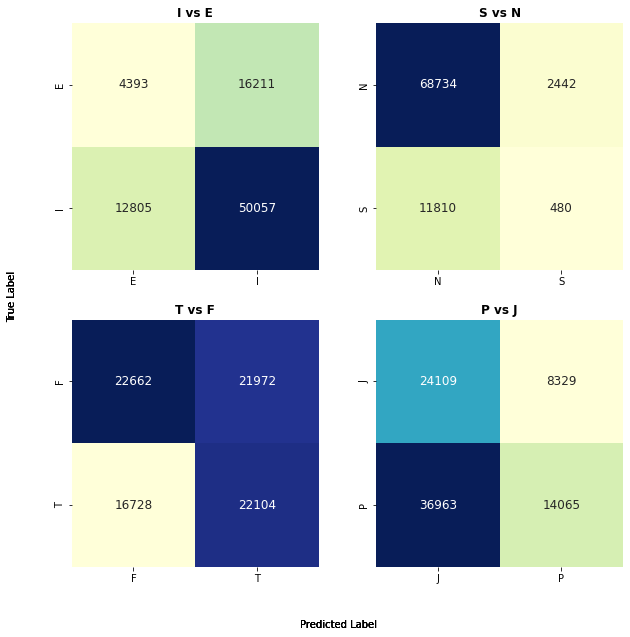

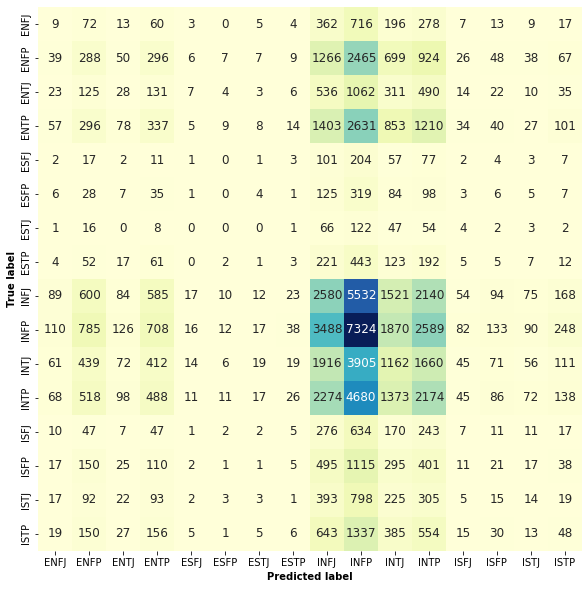

In [2]:
# %%timeit -n 1 -r 1
from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(n_estimators = 5, max_depth=10, max_features=10)
# for i in range(len(train_y)):
#     clf.fit(train_X, train_y[i])
#     print('done fitting')
#     Z = clf.predict(train_X)
#     print(accuracy_score(train_y[i], Z))

#     print(clf.feature_importances_)
#     plt.scatter(train_X.iloc[:, -3], train_X.iloc[:, -1], c=Z, alpha=0.3)
#     print(np.unique(Z))
#     print(accuracy_score(train_y[2], Z))

best_acc = 5 * [0]
best_d = 5 * [0]
best_f = 5 * [0]
best_c = 5 * [0]
best_thresh = 5 * [0]
best_model = 5 * [0]
thresholds = np.linspace(0.3, 0.7, 11)

for i in range(len(train_y)):
    for d in [5, 10, 20]: # depth
        for f in [3, 5, 10]: # num features
            for c in ['gini']: # , 'entropy']: # criterion
                clf = RandomForestClassifier(max_depth=d,
                                             max_features=f,
                                             criterion=c,
                                             n_estimators=5)
                clf.fit(train_X, train_y[i])
    #             print('done fitting')
                if i < 5: 
                    pred_y = clf.predict_proba(valid_X)[:,1]
                    acc_score_t = []
                    for t in thresholds:
                        acc_score_t.append(balanced_accuracy_score(valid_y[i], (pred_y > t).astype('int')))
                    best_t = thresholds[np.argmax(np.array(acc_score_t))]
                    acc_score = balanced_accuracy_score(valid_y[i], (pred_y > best_t).astype('int'))
                else:
                    pred_y = clf.predict(valid_X)
                    acc_score = balanced_accuracy_score(valid_y[i], pred_y)
                #             Z = clf.predict(train_X)
    #             print(f"training accuracy  : {accuracy_score(train_y[i], clf.predict(train_X))}")
#                 acc_score = accuracy_score(valid_y[i], clf.predict(valid_X))
                print(f"valid set | y={i} | depth={d: <2} | features={f: <2} | c={c: <7} | {best_t} | {acc_score}")
                if acc_score > best_acc[i]:
                    best_acc[i] = acc_score
                    best_d[i] = d
                    best_f[i] = f
                    best_c[i] = c
                    best_thresh[i] = best_t
                    best_model[i] = clf
#                     print(clf)
print(best_acc)
print(best_d)
print(best_f)
print(best_c)
print(best_thresh)


cumulative_score = np.zeros(len(test_y[0]))
fig,axs = plt.subplots(2,2, figsize=(10,10))

for i in range(len(train_y)):
    if i < 4:
        pred_y = best_model[i].predict_proba(test_X)[:,1]
        decode_y = (pred_y > best_thresh[i]).astype('int')
        acc_score = accuracy_score(test_y[i], decode_y)
        bal_acc_score = balanced_accuracy_score(test_y[i], decode_y)
        conf_mat = confusion_matrix(test_y[i], decode_y)
        cumulative_score += (test_y[i] == decode_y)
        m,n = divmod(i,2)
        seaborn.heatmap(conf_mat,
                         annot=True,
                         annot_kws={"size": 12},
                         cmap='YlGnBu',
                         cbar=False,
                         square=True,
                         fmt='.0f',
                         ax = axs[m, n])
        axs[m, n].set_title(comparison_name[i],fontweight="bold")
        axs[m, n].set_xticklabels(ids[i])
        axs[m, n].set_yticklabels(ids[i])
        fig.text(0.5, 0.04, 'Predicted Label', ha='center')
        fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')
    print(f"test set | y={i} | {acc_score} | {bal_acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")

        
fig2, ax2 = plt.subplots(1,1, figsize = (10, 10))
for i in [4]:
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    bal_acc_score = balanced_accuracy_score(test_y[i], Z)
    conf_mat = confusion_matrix(test_y[i], Z)
    ax2 = seaborn.heatmap(conf_mat,
                          annot=True,
                          annot_kws={"size": 12},
                          cmap='YlGnBu',
                          cbar=False,
                          square=True,
                          fmt='.0f')
    ax2.set_xticklabels(ids[4])
    ax2.set_yticklabels(ids[4])
    ax2.set_ylabel('True label',fontweight="bold")
    ax2.set_xlabel('Predicted label',fontweight="bold")
    print(f"test set | y={i} | depth={best_d[i]: <2} | features={best_f[i]: <2} | c={best_c[i]: <7} | {acc_score} | {bal_acc_score}")





valid set | y=0 | alpha=1e-05   | pen=l2 | 0.7 | 0.5003408123246397
valid set | y=0 | alpha=1e-05   | pen=l1 | 0.7 | 0.5121240770123371
valid set | y=0 | alpha=0.001   | pen=l2 | 0.7 | 0.5017069529282133
valid set | y=0 | alpha=0.001   | pen=l1 | 0.7 | 0.501287925012186
valid set | y=0 | alpha=0.1     | pen=l2 | 0.3 | 0.5
valid set | y=0 | alpha=0.1     | pen=l1 | 0.3 | 0.5
valid set | y=0 | alpha=10      | pen=l2 | 0.3 | 0.5
valid set | y=0 | alpha=10      | pen=l1 | 0.3 | 0.5
valid set | y=0 | alpha=1000    | pen=l2 | 0.3 | 0.5
valid set | y=0 | alpha=1000    | pen=l1 | 0.3 | 0.5
valid set | y=1 | alpha=1e-05   | pen=l2 | 0.3 | 0.5002443549912441
valid set | y=1 | alpha=1e-05   | pen=l1 | 0.3 | 0.5003019851472104
valid set | y=1 | alpha=0.001   | pen=l2 | 0.33999999999999997 | 0.5
valid set | y=1 | alpha=0.001   | pen=l1 | 0.3 | 0.5
valid set | y=1 | alpha=0.1     | pen=l2 | 0.3 | 0.5
valid set | y=1 | alpha=0.1     | pen=l1 | 0.3 | 0.5
valid set | y=1 | alpha=10      | pen=l2 | 0.3 

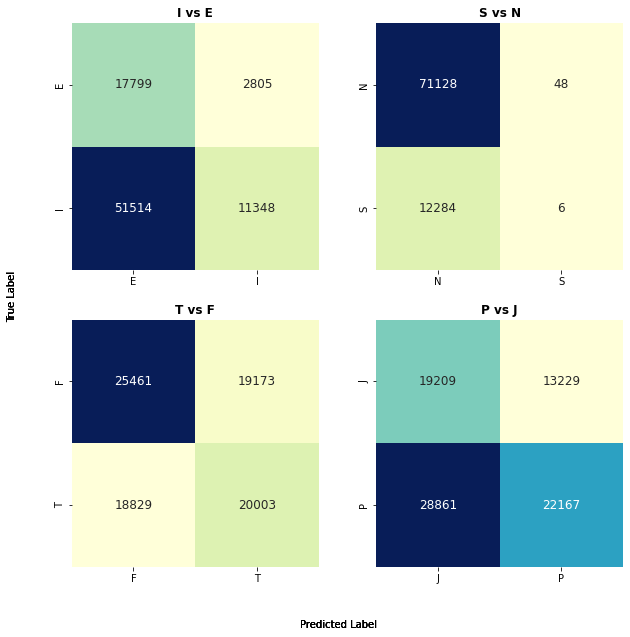

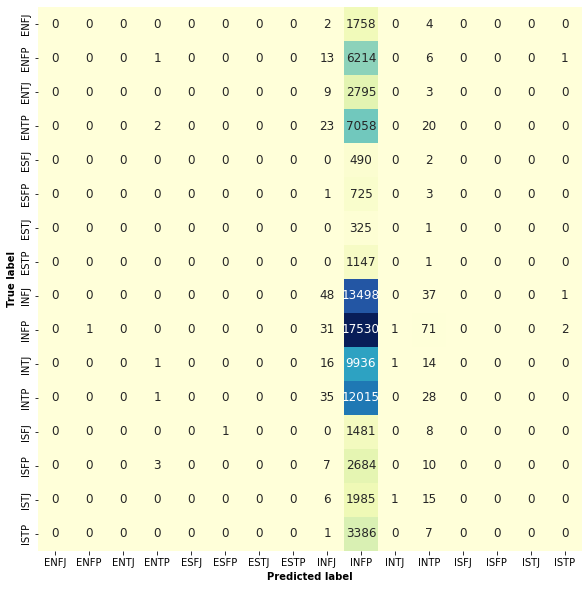

In [3]:
%%timeit -n 1 -r 1
from sklearn.linear_model import SGDClassifier

best_acc = 5 * [0]
best_a = 5 * [1e-5]
best_p = 5 * ['l2']
best_thresh = 5 * [0]
best_model = 5 * [0]
thresholds = np.linspace(0.3, 0.7, 11)

for i in range(len(train_y)):
    for a in [0.00001, 0.001, 0.1, 10, 1000]: # regularisation term
        for p in ['l2', 'l1']: # regularisation type
            clf = SGDClassifier(alpha = a,
                                penalty = p,
                                loss='modified_huber')
            clf.fit(train_X, train_y[i])
            if i < 5: 
                pred_y = clf.predict_proba(valid_X)[:,1]
                acc_score_t = []
                for t in thresholds:
                    acc_score_t.append(balanced_accuracy_score(valid_y[i],
                                                               (pred_y > t).astype('int')))
                best_t = thresholds[np.argmax(np.array(acc_score_t))]
                acc_score = balanced_accuracy_score(valid_y[i],
                                                    (pred_y > best_t).astype('int'))
            else:
                pred_y = clf.predict(valid_X)
                acc_score = balanced_accuracy_score(valid_y[i], pred_y)
            print(f"valid set | y={i} | alpha={a: <7} | pen={p: <2} | {best_t} | {acc_score}")
            if acc_score > best_acc[i]:
                best_acc[i] = acc_score
                best_a[i] = a
                best_p[i] = p
                best_thresh[i] = best_t
                best_model[i] = clf
#                 print(clf)
print(best_acc)
print(best_a)
print(best_p)
print(best_thresh)


cumulative_score = np.zeros(len(test_y[0]))
fig,axs = plt.subplots(2,2, figsize=(10,10))

for i in range(len(train_y)):
    if i < 4:
        pred_y = best_model[i].predict_proba(test_X)[:,1]
        decode_y = (pred_y > best_thresh[i]).astype('int')
        acc_score = accuracy_score(test_y[i], decode_y)
        bal_acc_score = balanced_accuracy_score(test_y[i], decode_y)
        conf_mat = confusion_matrix(test_y[i], decode_y)
        cumulative_score += (test_y[i] == decode_y)
        m,n = divmod(i,2)
        seaborn.heatmap(conf_mat,
                         annot=True,
                         annot_kws={"size": 12},
                         cmap='YlGnBu',
                         cbar=False,
                         square=True,
                         fmt='.0f',
                         ax = axs[m, n])
        axs[m, n].set_title(comparison_name[i],fontweight="bold")
        axs[m, n].set_xticklabels(ids[i])
        axs[m, n].set_yticklabels(ids[i])
        fig.text(0.5, 0.04, 'Predicted Label', ha='center')
        fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')
    print(f"test set | y={i} | {acc_score} | {bal_acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")

        
fig2, ax2 = plt.subplots(1,1, figsize = (10, 10))
for i in [4]:
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    bal_acc_score = balanced_accuracy_score(test_y[i], Z)
    conf_mat = confusion_matrix(test_y[i], Z)
    ax2 = seaborn.heatmap(conf_mat,
                          annot=True,
                          annot_kws={"size": 12},
                          cmap='YlGnBu',
                          cbar=False,
                          square=True,
                          fmt='.0f')
    ax2.set_xticklabels(ids[4])
    ax2.set_yticklabels(ids[4])
    ax2.set_ylabel('True label',fontweight="bold")
    ax2.set_xlabel('Predicted label',fontweight="bold")
    print(f"test set | y={i} | alpha={best_a[i]: <7} | pen={best_p[i]: <2} | {acc_score} | {bal_acc_score}")




cumulative_score = np.zeros(len(test_y[0]))
fig,axs = plt.subplots(2,2, figsize=(10,10))


for i in range(len(train_y)):
#     clf = SGDClassifier(alpha = best_a[i], penalty = best_p[i]).fit(train_X, train_y[i])
#     Z = clf.predict(valid_X)
    if i < 4:
        pred_y = best_model[i].predict_proba(test_X)[:,1]
        acc_score = accuracy_score(test_y[i], (pred_y > best_thresh[i]))
        conf_mat = confusion_matrix(test_y[i], (pred_y > best_thresh[i]).astype('int'))
        cumulative_score += (test_y[i] == Z)
        m,n = divmod(i,2)
        seaborn.heatmap(conf_mat,
                         annot=True,
                         annot_kws={"size": 12},
                         cmap='YlGnBu',
                         cbar=False,
                         square=True,
                         fmt='.0f',
                         ax = axs[m, n])
        axs[m, n].set_title(comparison_name[i],fontweight="bold")
        axs[m, n].set_xticklabels(ids[i])
        axs[m, n].set_yticklabels(ids[i])
        fig.text(0.5, 0.04, 'Predicted Label', ha='center')
        fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')    
    print(f"test set | y={i} | alpha={best_a[i]: <6} | {best_p[i]} reg | {acc_score}")
    
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")
        
fig2, ax2 = plt.subplots(1,1, figsize = (10, 10))
for i in [4]:
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    conf_mat = confusion_matrix(test_y[i], Z)
    ax2 = seaborn.heatmap(conf_mat,
                          annot=True,
                          annot_kws={"size": 12},
                          cmap='YlGnBu',
                          cbar=False,
                          square=True,
                          fmt='.0f')
    ax2.set_xticklabels(ids[4])
    ax2.set_yticklabels(ids[4])
    ax2.set_ylabel('True label',fontweight="bold")
    ax2.set_xlabel('Predicted label',fontweight="bold")
        


valid set | y=0 | alpha=0.0001  | pen=l2 | 0.3 | 0.5
valid set | y=0 | alpha=0.01    | pen=l2 | 0.7 | 0.5009068924607241
valid set | y=0 | alpha=1.0     | pen=l2 | 0.7 | 0.5015502819885921
valid set | y=0 | alpha=100.0   | pen=l2 | 0.7 | 0.5015479372479125
valid set | y=0 | alpha=10000.0 | pen=l2 | 0.7 | 0.5015479372479125
valid set | y=1 | alpha=0.0001  | pen=l2 | 0.3 | 0.5
valid set | y=1 | alpha=0.01    | pen=l2 | 0.33999999999999997 | 0.5
valid set | y=1 | alpha=1.0     | pen=l2 | 0.3 | 0.5001167522535125
valid set | y=1 | alpha=100.0   | pen=l2 | 0.3 | 0.5001167522535125
valid set | y=1 | alpha=10000.0 | pen=l2 | 0.3 | 0.5001167522535125
valid set | y=2 | alpha=0.0001  | pen=l2 | 0.45999999999999996 | 0.5205316744142057
valid set | y=2 | alpha=0.01    | pen=l2 | 0.45999999999999996 | 0.534901185129502
valid set | y=2 | alpha=1.0     | pen=l2 | 0.45999999999999996 | 0.5349886607609464
valid set | y=2 | alpha=100.0   | pen=l2 | 0.45999999999999996 | 0.5350852236440178
valid set | y=

C:\Users\donho\Anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


valid set | y=4 | alpha=0.01    | pen=l2 | 0.3 | 0.0625


C:\Users\donho\Anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


valid set | y=4 | alpha=1.0     | pen=l2 | 0.3 | 0.0625


C:\Users\donho\Anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


valid set | y=4 | alpha=100.0   | pen=l2 | 0.3 | 0.06251322471434617


C:\Users\donho\Anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


valid set | y=4 | alpha=10000.0 | pen=l2 | 0.3 | 0.06251322471434617
[0.5015502819885921, 0.5001167522535125, 0.5350852236440178, 0.5063101661362738, 0.06251322471434617]
[1.0, 1.0, 100.0, 1.0, 100.0]
['l2', 'l2', 'l2', 'l2', 'l2']
[0.7, 0.3, 0.45999999999999996, 0.6199999999999999, 0.3]
test set | y=0 | 0.7494189250712865 | 0.5009357866795219
test set | y=1 | 0.8525747010758872 | 0.4999619446878401
test set | y=2 | 0.542460403038363 | 0.5430984014026901
test set | y=3 | 0.4238132892435243 | 0.5051610471419254
test set | y=4 | 0.4238132892435243 | 0.5051610471419254
all 4 correct: 0.15667457407806773
at least 3 correct: 0.5445091414468166
test set | y=4 | alpha=100.0   | pen=l2 | 0.21092420865981357 | 0.0631168556486137
3min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


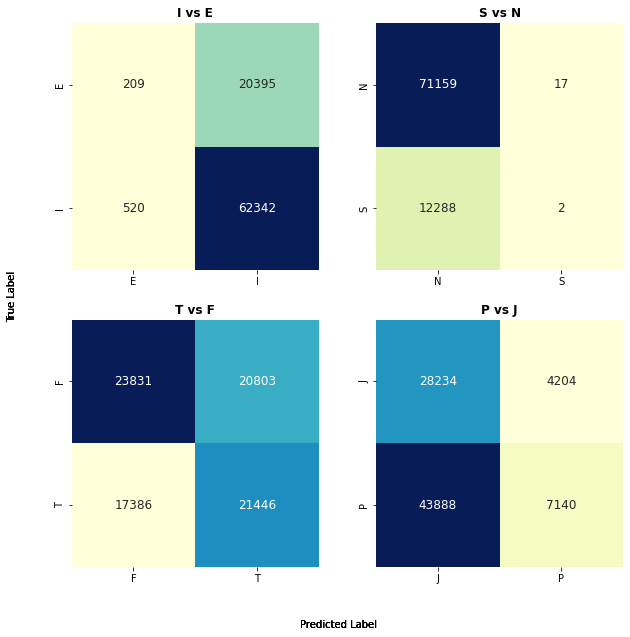

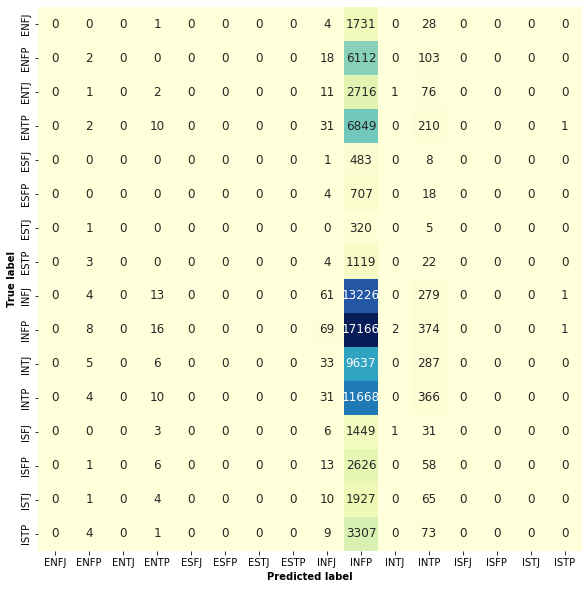

In [5]:
%%timeit -n 1 -r 1
from sklearn.linear_model import LogisticRegression
'''    
best_acc = 5 * [0]
best_a = 5 * [1e-5]
best_p = 5 * ['l2']
best_thresh = 5 * [0]
best_model = 5 * [0]
thresholds = np.arange(0., 1.1, 0.1)

for i in range(len(train_y)):
    for a in [0.0001, 0.01, 1., 100., 10000.]: # regularisation term
        for p in ['l2']: # regularisation type
            clf = LogisticRegression(C = a, penalty = p)
            clf.fit(train_X, train_y[i])
#             print('done fitting')
#             Z = clf.predict(train_X)
#             print(f"training accuracy  : {accuracy_score(train_y[i], clf.predict(train_X))}")
            acc_score = accuracy_score(valid_y[i], clf.predict(valid_X))
            print(f"valid set | y={i} | C={a: <6} | {p} reg | {acc_score}")
            if acc_score > best_acc[i]:
                best_acc[i] = acc_score
                best_a[i] = a
                best_p[i] = p
                best_model[i] = clf
print(best_acc)
print(best_a)
print(best_p)

#     plt.scatter(train_X.iloc[:, -3], train_X.iloc[:, -1], c=Z, alpha=0.3)
#     plt.show()
cumulative_score = np.zeros(len(test_y[0]))
for i in range(len(train_y)):
#     clf = SGDClassifier(alpha = best_a[i], penalty = best_p[i]).fit(train_X, train_y[i])
#     Z = clf.predict(valid_X)
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    if i < 4:
        cumulative_score += (test_y[i] == Z)
    print(f"test set | y={i} | C={best_a[i]: <7} | {best_p[i]} reg | {acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")
'''
###########################


best_acc = 5 * [0]
best_a = 5 * [1e-5]
best_p = 5 * ['l2']
best_thresh = 5 * [0]
best_model = 5 * [0]
thresholds = np.linspace(0.3, 0.7, 11)

for i in range(len(train_y)):
    for a in [0.0001, 0.01, 1., 100., 10000.]: # regularisation term
        for p in ['l2']: # regularisation type
            clf = LogisticRegression(C = a, penalty = p)
            clf.fit(train_X, train_y[i])
            if i < 5: 
                pred_y = clf.predict_proba(valid_X)[:,1]
                acc_score_t = []
                for t in thresholds:
                    acc_score_t.append(balanced_accuracy_score(valid_y[i],
                                                               (pred_y > t).astype('int')))
                best_t = thresholds[np.argmax(np.array(acc_score_t))]
                acc_score = balanced_accuracy_score(valid_y[i],
                                                    (pred_y > best_t).astype('int'))
            else:
                pred_y = clf.predict(valid_X)
                acc_score = balanced_accuracy_score(valid_y[i], pred_y)
            print(f"valid set | y={i} | alpha={a: <7} | pen={p: <2} | {best_t} | {acc_score}")
            if acc_score > best_acc[i]:
                best_acc[i] = acc_score
                best_a[i] = a
                best_p[i] = p
                best_thresh[i] = best_t
                best_model[i] = clf
#                 print(clf)
print(best_acc)
print(best_a)
print(best_p)
print(best_thresh)


cumulative_score = np.zeros(len(test_y[0]))
fig,axs = plt.subplots(2,2, figsize=(10,10))

for i in range(len(train_y)):
    if i < 4:
        pred_y = best_model[i].predict_proba(test_X)[:,1]
        decode_y = (pred_y > best_thresh[i]).astype('int')
        acc_score = accuracy_score(test_y[i], decode_y)
        bal_acc_score = balanced_accuracy_score(test_y[i], decode_y)
        conf_mat = confusion_matrix(test_y[i], decode_y)
        cumulative_score += (test_y[i] == decode_y)
        m,n = divmod(i,2)
        seaborn.heatmap(conf_mat,
                         annot=True,
                         annot_kws={"size": 12},
                         cmap='YlGnBu',
                         cbar=False,
                         square=True,
                         fmt='.0f',
                         ax = axs[m, n])
        axs[m, n].set_title(comparison_name[i],fontweight="bold")
        axs[m, n].set_xticklabels(ids[i])
        axs[m, n].set_yticklabels(ids[i])
        fig.text(0.5, 0.04, 'Predicted Label', ha='center')
        fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')
    print(f"test set | y={i} | {acc_score} | {bal_acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")

        
fig2, ax2 = plt.subplots(1,1, figsize = (10, 10))
for i in [4]:
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    bal_acc_score = balanced_accuracy_score(test_y[i], Z)
    conf_mat = confusion_matrix(test_y[i], Z)
    ax2 = seaborn.heatmap(conf_mat,
                          annot=True,
                          annot_kws={"size": 12},
                          cmap='YlGnBu',
                          cbar=False,
                          square=True,
                          fmt='.0f')
    ax2.set_xticklabels(ids[4])
    ax2.set_yticklabels(ids[4])
    ax2.set_ylabel('True label',fontweight="bold")
    ax2.set_xlabel('Predicted label',fontweight="bold")
    print(f"test set | y={i} | alpha={best_a[i]: <7} | pen={best_p[i]: <2} | {acc_score} | {bal_acc_score}")



valid set | y=0 | 0.7 | 0.5101026220255674
valid set | y=1 | 0.7 | 0.5021080143377046
valid set | y=2 | 0.49999999999999994 | 0.5327171092588838
valid set | y=3 | 0.5399999999999999 | 0.5101885729210311
valid set | y=4 | 0.3 | 0.0625
[0.5101026220255674, 0.5021080143377046, 0.5327171092588838, 0.5101885729210311, 0.0625]
[0.7, 0.7, 0.49999999999999994, 0.5399999999999999, 0.3]
test set | y=0 | 0.6786955167373542 | 0.5130212101548599
test set | y=1 | 0.8399108619078427 | 0.5015235465772145
test set | y=2 | 0.5503079098075864 | 0.534377841577366
test set | y=3 | 0.5298804303548751 | 0.5104943302865537
all 4 correct: 0.16617544868569237
at least 3 correct: 0.5594253947715238
test set | y=4 | 0.1739870126758201 | 0.06551527731360285


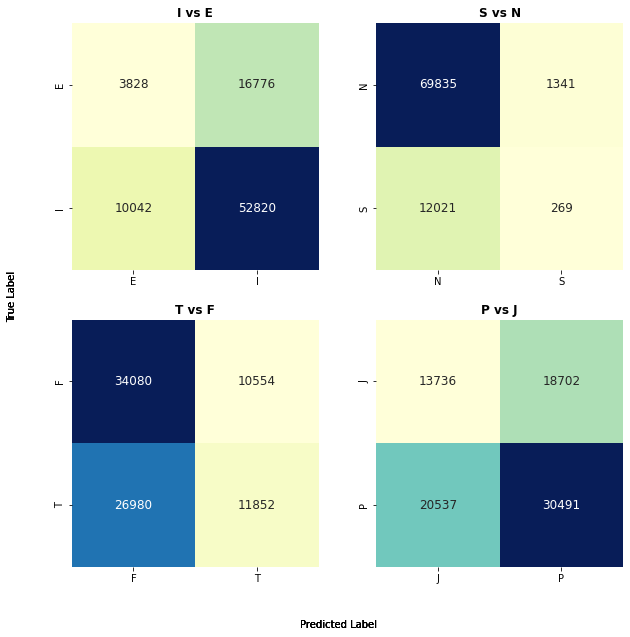

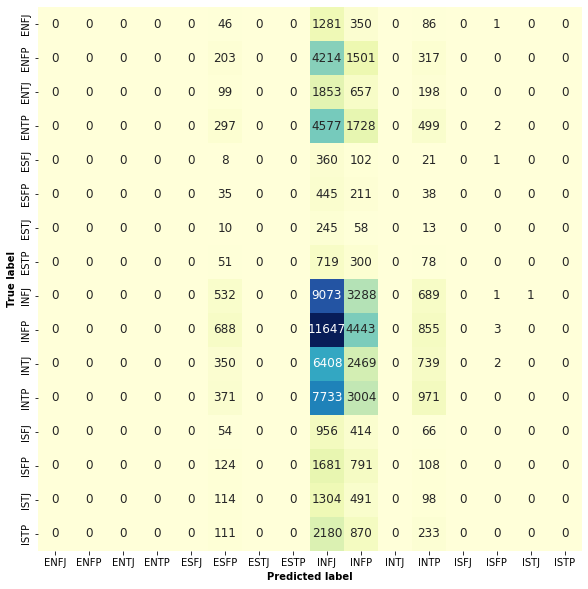

In [6]:
# %%timeit -n 1 -r 1
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn

best_acc = 5 * [0]
best_thresh = 5 * [0]
best_model = 5 * [0]
thresholds = np.linspace(0.3, 0.7, 11)

for i in range(len(train_y)):
    clf = GaussianNB()
    clf.fit(train_X, train_y[i])
    if i < 5: 
        pred_y = clf.predict_proba(valid_X)[:,1]
        acc_score_t = []
        for t in thresholds:
            acc_score_t.append(balanced_accuracy_score(valid_y[i], (pred_y > t).astype('int')))
        best_t = thresholds[np.argmax(np.array(acc_score_t))]
        acc_score = balanced_accuracy_score(valid_y[i], (pred_y > best_t).astype('int'))
    else:
        pred_y = clf.predict(valid_X)
        acc_score = balanced_accuracy_score(valid_y[i], pred_y)
    print(f"valid set | y={i} | {best_t} | {acc_score}")
    if acc_score > best_acc[i]:
        best_acc[i] = acc_score
        best_thresh[i] = best_t
        best_model[i] = clf
#         print(clf)
print(best_acc)
print(best_thresh)


cumulative_score = np.zeros(len(test_y[0]))
fig,axs = plt.subplots(2,2, figsize=(10,10))

for i in range(len(train_y)):
    if i < 4:
        pred_y = best_model[i].predict_proba(test_X)[:,1]
        decode_y = (pred_y > best_thresh[i]).astype('int')
        acc_score = accuracy_score(test_y[i], decode_y)
        bal_acc_score = balanced_accuracy_score(test_y[i], decode_y)
        conf_mat = confusion_matrix(test_y[i], decode_y)
        cumulative_score += (test_y[i] == decode_y)
        m,n = divmod(i,2)
        seaborn.heatmap(conf_mat,
                         annot=True,
                         annot_kws={"size": 12},
                         cmap='YlGnBu',
                         cbar=False,
                         square=True,
                         fmt='.0f',
                         ax = axs[m, n])
        axs[m, n].set_title(comparison_name[i],fontweight="bold")
        axs[m, n].set_xticklabels(ids[i])
        axs[m, n].set_yticklabels(ids[i])
        fig.text(0.5, 0.04, 'Predicted Label', ha='center')
        fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')
        print(f"test set | y={i} | {acc_score} | {bal_acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")

        
fig2, ax2 = plt.subplots(1,1, figsize = (10, 10))
for i in [4]:
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    bal_acc_score = balanced_accuracy_score(test_y[i], Z)
    conf_mat = confusion_matrix(test_y[i], Z)
    ax2 = seaborn.heatmap(conf_mat,
                          annot=True,
                          annot_kws={"size": 12},
                          cmap='YlGnBu',
                          cbar=False,
                          square=True,
                          fmt='.0f')
    ax2.set_xticklabels(ids[4])
    ax2.set_yticklabels(ids[4])
    ax2.set_ylabel('True label',fontweight="bold")
    ax2.set_xlabel('Predicted label',fontweight="bold")
    print(f"test set | y={i} | {acc_score} | {bal_acc_score}")

valid set | y=0 | 0.58 | 0.5026078270857373
valid set | y=1 | 0.42 | 0.5010554234700376
valid set | y=2 | 0.49999999999999994 | 0.5255691321617187
valid set | y=3 | 0.3 | 0.5
valid set | y=4 | 0.3 | 0.0625
[0.5026078270857373, 0.5010554234700376, 0.5255691321617187, 0.5, 0.0625]
[0.58, 0.42, 0.49999999999999994, 0.3, 0.3]
test set | y=0 | 0.2705892219586418 | 0.5084321093878305
test set | y=1 | 0.8446313468957419 | 0.49941083028416794
test set | y=2 | 0.5453238444396521 | 0.5247684203586783
test set | y=3 | 0.6113627105647809 | 0.5
test set | y=4 | 0.6113627105647809 | 0.5
all 4 correct: 0.08735293412886684
at least 3 correct: 0.41089785062181006
test set | y=4 | 0.21177485443174465 | 0.06376182785876776
19.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


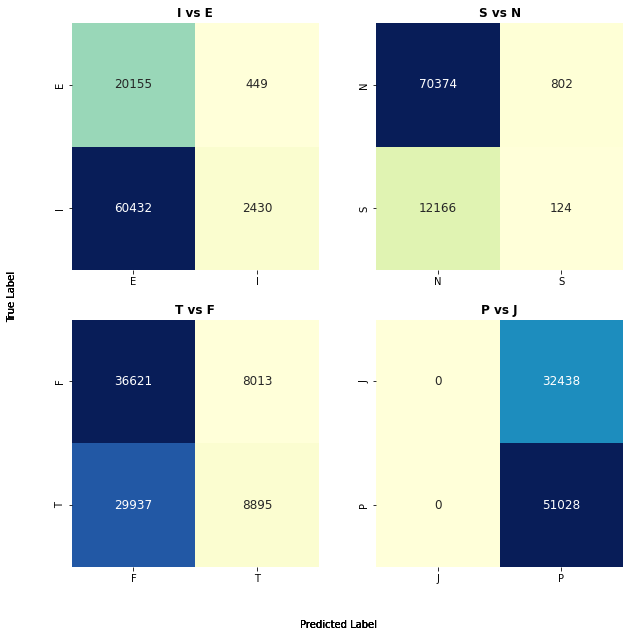

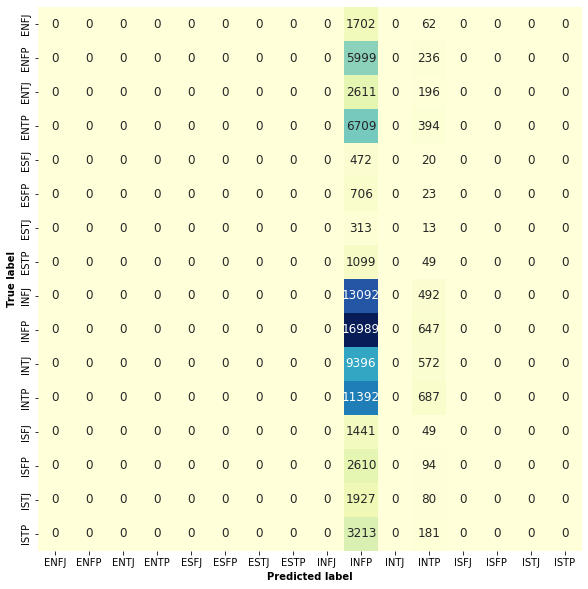

In [7]:
%%timeit -n 1 -r 1
from sklearn.ensemble import AdaBoostClassifier

best_acc = 5 * [0]
best_thresh = 5 * [0]
best_model = 5 * [0]
thresholds = np.linspace(0.3, 0.7, 11)

for i in range(len(train_y)):
    clf = AdaBoostClassifier(n_estimators=5)
    clf.fit(train_X, train_y[i])
    if i < 5: 
        pred_y = clf.predict_proba(valid_X)[:,1]
        acc_score_t = []
        for t in thresholds:
            acc_score_t.append(balanced_accuracy_score(valid_y[i], (pred_y > t).astype('int')))
        best_t = thresholds[np.argmax(np.array(acc_score_t))]
        acc_score = balanced_accuracy_score(valid_y[i], (pred_y > best_t).astype('int'))
    else:
        pred_y = clf.predict(valid_X)
        acc_score = balanced_accuracy_score(valid_y[i], pred_y)
    print(f"valid set | y={i} | {best_t} | {acc_score}")
    if acc_score > best_acc[i]:
        best_acc[i] = acc_score
        best_thresh[i] = best_t
        best_model[i] = clf
#         print(clf)
print(best_acc)
print(best_thresh)


cumulative_score = np.zeros(len(test_y[0]))
fig,axs = plt.subplots(2,2, figsize=(10,10))

for i in range(len(train_y)):
    if i < 4:
        pred_y = best_model[i].predict_proba(test_X)[:,1]
        decode_y = (pred_y > best_thresh[i]).astype('int')
        acc_score = accuracy_score(test_y[i], decode_y)
        bal_acc_score = balanced_accuracy_score(test_y[i], decode_y)
        conf_mat = confusion_matrix(test_y[i], decode_y)
        cumulative_score += (test_y[i] == decode_y)
        m,n = divmod(i,2)
        seaborn.heatmap(conf_mat,
                         annot=True,
                         annot_kws={"size": 12},
                         cmap='YlGnBu',
                         cbar=False,
                         square=True,
                         fmt='.0f',
                         ax = axs[m, n])
        axs[m, n].set_title(comparison_name[i],fontweight="bold")
        axs[m, n].set_xticklabels(ids[i])
        axs[m, n].set_yticklabels(ids[i])
        fig.text(0.5, 0.04, 'Predicted Label', ha='center')
        fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')
    print(f"test set | y={i} | {acc_score} | {bal_acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")

        
fig2, ax2 = plt.subplots(1,1, figsize = (10, 10))
for i in [4]:
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    bal_acc_score = balanced_accuracy_score(test_y[i], Z)
    conf_mat = confusion_matrix(test_y[i], Z)
    ax2 = seaborn.heatmap(conf_mat,
                          annot=True,
                          annot_kws={"size": 12},
                          cmap='YlGnBu',
                          cbar=False,
                          square=True,
                          fmt='.0f')
    ax2.set_xticklabels(ids[4])
    ax2.set_yticklabels(ids[4])
    ax2.set_ylabel('True label',fontweight="bold")
    ax2.set_xlabel('Predicted label',fontweight="bold")
    print(f"test set | y={i} | {acc_score} | {bal_acc_score}")
    
    


valid set | y=0 | n neighbours=1  | 0.6623164274035072
valid set | y=0 | n neighbours=11 | 0.773892564091025
valid set | y=0 | n neighbours=21 | 0.7868682777552766
valid set | y=1 | n neighbours=1  | 0.7614868817784978
valid set | y=1 | n neighbours=11 | 0.8459415267839732
valid set | y=1 | n neighbours=21 | 0.8469465820620135
valid set | y=2 | n neighbours=1  | 0.5119331563235978
valid set | y=2 | n neighbours=11 | 0.5383346084034621
valid set | y=2 | n neighbours=21 | 0.5464500547530114
valid set | y=3 | n neighbours=1  | 0.5198385911225117
valid set | y=3 | n neighbours=11 | 0.5499602478136297
valid set | y=3 | n neighbours=21 | 0.5595007725424899
valid set | y=4 | n neighbours=1  | 0.1340473726054933
valid set | y=4 | n neighbours=11 | 0.171309422018211
valid set | y=4 | n neighbours=21 | 0.18427013485741717
[0.7868682777552766, 0.8469465820620135, 0.5464500547530114, 0.5595007725424899, 0.18427013485741717]
[21, 21, 21, 21, 21]
test set | y=0 | n neighbours=21 | 0.7507727697505571

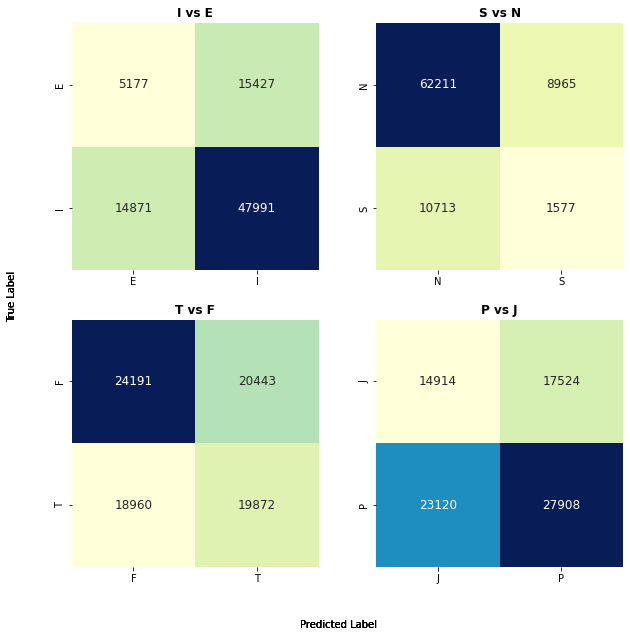

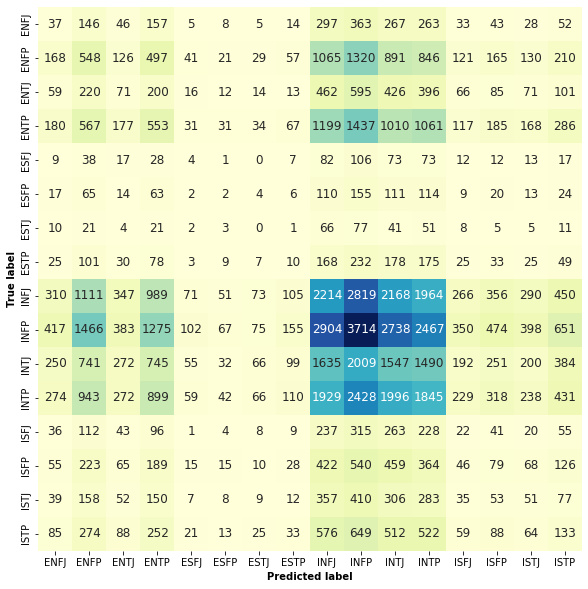

In [8]:
%%timeit -n 1 -r 1
import time
start = time.time()
from sklearn.neighbors import KNeighborsClassifier

best_acc = 5 * [0]
best_k = 5 * [1.]
best_model = 5 * [0]

for i in range(len(train_y)):
    for k in [1, 11, 21]: # number of neighbours
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(train_X, train_y[i])
#             print('done fitting')
#             Z = clf.predict(train_X)
#             print(f"training accuracy  : {accuracy_score(train_y[i], clf.predict(train_X))}")
        acc_score = accuracy_score(valid_y[i], clf.predict(valid_X))
        print(f"valid set | y={i} | n neighbours={k: <2} | {acc_score}")
        if acc_score > best_acc[i]:
            best_acc[i] = acc_score
            best_k[i] = k
            best_model[i] = clf
print(best_acc)
print(best_k)

#     plt.scatter(train_X.iloc[:, -3], train_X.iloc[:, -1], c=Z, alpha=0.3)
#     plt.show()
cumulative_score = np.zeros(len(test_y[0]))
for i in range(len(train_y)):
#     clf = SGDClassifier(alpha = best_a[i], penalty = best_p[i]).fit(train_X, train_y[i])
#     Z = clf.predict(valid_X)
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    if i < 4:
        cumulative_score += (test_y[i] == Z)
    print(f"test set | y={i} | n neighbours={best_k[i]: <2} | {acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")


    
####################################

best_acc = 5 * [0]
best_k = 5 * [1.]
best_thresh = 5 * [0]
best_model = 5 * [0]
thresholds = np.linspace(0.3, 0.7, 11)

for i in range(len(train_y)):
    for k in [1, 11, 21]: # number of neighbours
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(train_X, train_y[i])
        if i < 5: 
            pred_y = clf.predict_proba(valid_X)[:,1]
            acc_score_t = []
            for t in thresholds:
                acc_score_t.append(balanced_accuracy_score(valid_y[i],
                                                           (pred_y > t).astype('int')))
            best_t = thresholds[np.argmax(np.array(acc_score_t))]
            acc_score = balanced_accuracy_score(valid_y[i],
                                                (pred_y > best_t).astype('int'))
        else:
            pred_y = clf.predict(valid_X)
            acc_score = balanced_accuracy_score(valid_y[i], pred_y)
        print(f"valid set | y={i} | k={k: <2} | {best_t} | {acc_score}")
        if acc_score > best_acc[i]:
            best_acc[i] = acc_score
            best_k[i] = k
            best_thresh[i] = best_t
            best_model[i] = clf
#             print(clf)
print(best_acc)
print(best_k)
print(best_thresh)


cumulative_score = np.zeros(len(test_y[0]))
fig,axs = plt.subplots(2,2, figsize=(10,10))

for i in range(len(train_y)):
    if i < 4:
        pred_y = best_model[i].predict_proba(test_X)[:,1]
        decode_y = (pred_y > best_thresh[i]).astype('int')
        acc_score = accuracy_score(test_y[i], decode_y)
        bal_acc_score = balanced_accuracy_score(test_y[i], decode_y)
        conf_mat = confusion_matrix(test_y[i], decode_y)
        cumulative_score += (test_y[i] == decode_y)
        m,n = divmod(i,2)
        seaborn.heatmap(conf_mat,
                         annot=True,
                         annot_kws={"size": 12},
                         cmap='YlGnBu',
                         cbar=False,
                         square=True,
                         fmt='.0f',
                         ax = axs[m, n])
        axs[m, n].set_title(comparison_name[i],fontweight="bold")
        axs[m, n].set_xticklabels(ids[i])
        axs[m, n].set_yticklabels(ids[i])
        fig.text(0.5, 0.04, 'Predicted Label', ha='center')
        fig.text(0.04, 0.5, 'True Label', va='center', rotation='vertical')
    print(f"test set | y={i} | {acc_score} | {bal_acc_score}")
print(f"all 4 correct: {sum(cumulative_score==4) / len(cumulative_score)}")
print(f"at least 3 correct: {sum(cumulative_score>=3) / len(cumulative_score)}")

        
fig2, ax2 = plt.subplots(1,1, figsize = (10, 10))
for i in [4]:
    Z = best_model[i].predict(test_X)
    acc_score = accuracy_score(test_y[i], Z)
    bal_acc_score = balanced_accuracy_score(test_y[i], Z)
    conf_mat = confusion_matrix(test_y[i], Z)
    ax2 = seaborn.heatmap(conf_mat,
                          annot=True,
                          annot_kws={"size": 12},
                          cmap='YlGnBu',
                          cbar=False,
                          square=True,
                          fmt='.0f')
    ax2.set_xticklabels(ids[4])
    ax2.set_yticklabels(ids[4])
    ax2.set_ylabel('True label',fontweight="bold")
    ax2.set_xlabel('Predicted label',fontweight="bold")
    print(f"test set | y={i} | k={best_k[i]: <2} | {acc_score} | {bal_acc_score}")

